In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0    # 입력 이미지는 항상 깊이 차원이 있어야, Conv2D 층 사용 위해 추가
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


In [2]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

In [3]:
model.add(keras.layers.MaxPooling2D(2))

In [4]:
# (2,2) 풀링으로 인해 특성 맵의 크기는 절반, 32개의 필터를 사용했으니 깊이는32
# 따라서, 특성 맵의 크기는 (14,14,32)

In [6]:
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

In [7]:
# 같은 과정으로 특성 맵은 (7, 7, 64)
# (28,28,1) - (14,14,32) - (7,7,64)

In [8]:
# 3차원 특성 맵을 일렬로 펼칠 차례
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))    # 일렬로 펼치고 바로 전달하지 않고 중간에 밀집 은닉층 추가
model.add(keras.layers.Dropout(0.4))    # 드롭아웃으로 앙상블 효과
model.add(keras.layers.Dense(10, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

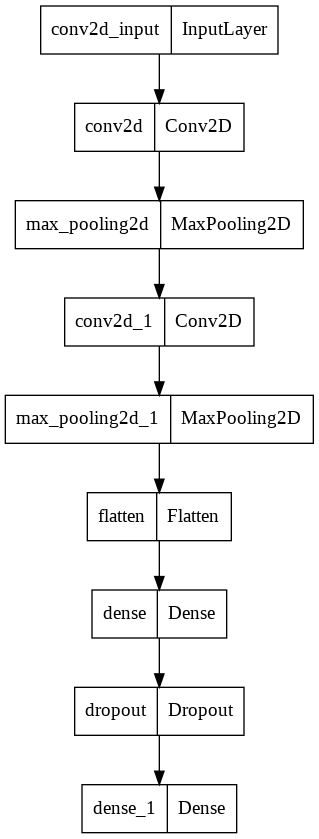

In [11]:
# 층의 구성을 그림으로 표현
keras.utils.plot_model(model)

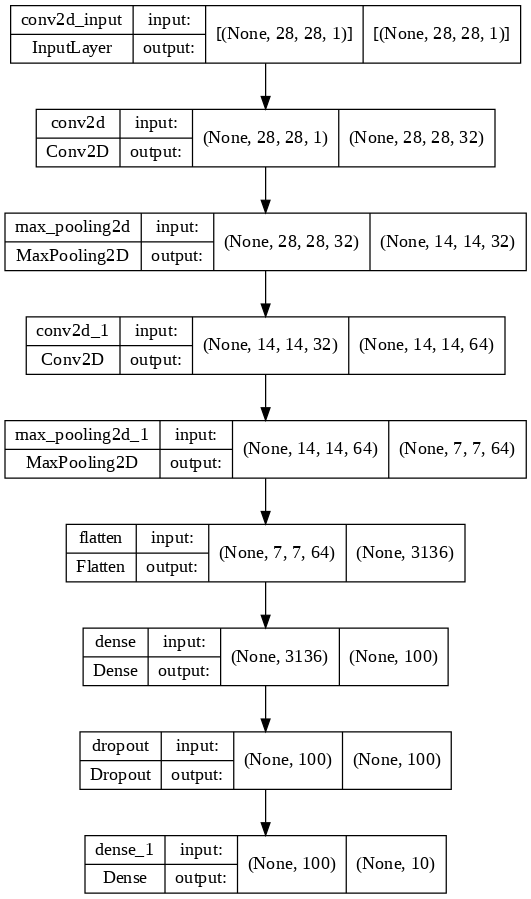

In [14]:
keras.utils.plot_model(model, show_shapes=True, to_file='cnn-architecture.png', dpi = 90)

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data = (val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 81s 53ms/step - loss: 0.5264 - accuracy: 0.8104 - val_loss: 0.3458 - val_accuracy: 0.8698
Epoch 2/20
1500/1500 [==============================] - 63s 42ms/step - loss: 0.3542 - accuracy: 0.8725 - val_loss: 0.2834 - val_accuracy: 0.8962
Epoch 3/20
1500/1500 [==============================] - 57s 38ms/step - loss: 0.3031 - accuracy: 0.8909 - val_loss: 0.2522 - val_accuracy: 0.9056
Epoch 4/20
1500/1500 [==============================] - 58s 39ms/step - loss: 0.2663 - accuracy: 0.9034 - val_loss: 0.2424 - val_accuracy: 0.9101
Epoch 5/20
1500/1500 [==============================] - 57s 38ms/step - loss: 0.2456 - accuracy: 0.9111 - val_loss: 0.2274 - val_accuracy: 0.9158
Epoch 6/20
1500/1500 [==============================] - 58s 39ms/step - loss: 0.2199 - accuracy: 0.9196 - val_loss: 0.2413 - val_accuracy: 0.9101
Epoch 7/20
1500/1500 [==============================] - 80s 53ms/step - loss: 0.2062 - accuracy: 0.9233 - val_loss: 0.2213 -

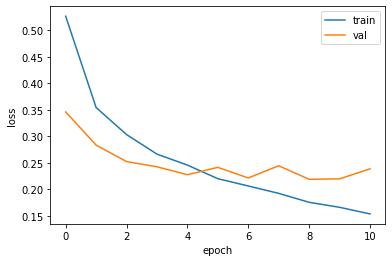

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [18]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 6s 17ms/step - loss: 0.2187 - accuracy: 0.9206


[0.21873942017555237, 0.9205833077430725]

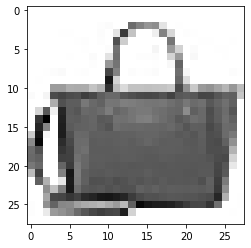

In [19]:
plt.imshow(val_scaled[0].reshape(28,28),cmap='gray_r')
plt.show()

In [20]:
preds = model.predict(val_scaled[0:1])    # fit(), predict(), evaluate() 모두 입력의 첫 번째 차원이 배치 차원일 것으로 기대
# 배열 슬라이싱은 인덱싱과 달리 선택된 원소가 하나여도 전체 차원 유지
# predict() 메서드는 10개 클래스에 대한 예측 확률 출력
print(preds)

[[1.0249290e-16 2.2218149e-23 6.5048029e-20 2.1410924e-19 1.7217948e-19
  2.3747528e-18 3.5551381e-16 5.3245606e-20 1.0000000e+00 4.7068221e-19]]


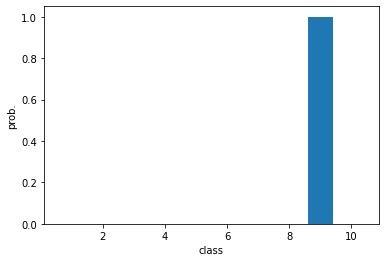

In [21]:
plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [22]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [23]:
import numpy as np
print(classes[np.argmax(preds)])

가방


In [25]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [26]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 5s 15ms/step - loss: 0.2457 - accuracy: 0.9142


[0.24573324620723724, 0.9142000079154968]